Potential energy curve to derive equilibrium bond length of H2 molecule.

converged SCF energy = -0.593827758535727
converged SCF energy = -0.934274362961992
converged SCF energy = -1.06763809097174
converged SCF energy = -1.11257928080196
converged SCF energy = -1.1151049457252
converged SCF energy = -1.09660990353635
converged SCF energy = -1.06758119004024
converged SCF energy = -1.03329165220603
converged SCF energy = -0.996697867713935
converged SCF energy = -0.959704683431047
converged SCF energy = -0.923603421796936
converged SCF energy = -0.889240853266787
converged SCF energy = -0.857133494953136
converged SCF energy = -0.827561018482364
converged SCF energy = -0.800634943034325
converged SCF energy = -0.77634602593143
converged SCF energy = -0.754599084387271
converged SCF energy = -0.735241741262531
converged SCF energy = -0.718089105297335
converged SCF energy = -0.702943599723527
Equilibrium bond length (Å): 0.763
Minimum HF energy (Hartree): -1.115105


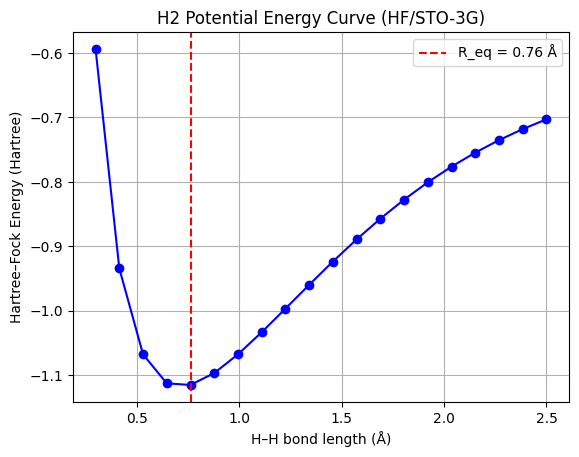

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf

def h2_energy(bond_length):
    mol = gto.Mole()
    mol.atom = f'''
    H 0 0 0
    H 0 0 {bond_length}
    '''
    mol.basis = 'sto-3g'
    mol.build()

    mf = scf.RHF(mol)
    energy = mf.kernel()
    return energy

bond_lengths = np.linspace(0.3, 2.5, 20)
energies = [h2_energy(R) for R in bond_lengths]

min_index = np.argmin(energies)
bond_length_eq = bond_lengths[min_index]
energy_min = energies[min_index]

print(f"Equilibrium bond length (Å): {bond_length_eq:.3f}")
print(f"Minimum HF energy (Hartree): {energy_min:.6f}")

plt.plot(bond_lengths, energies, 'o-', color='blue')
plt.axvline(x=bond_length_eq, color='red', linestyle='--', label=f'R_eq = {bond_length_eq:.2f} Å')
plt.xlabel("H–H bond length (Å)")
plt.ylabel("Hartree–Fock Energy (Hartree)")
plt.title("H2 Potential Energy Curve (HF/STO-3G)")
plt.grid(True)
plt.legend()
plt.show()


Generate H2 hamiltonian

In [2]:

import numpy as np
from pyscf import gto
from openfermion import MolecularData, get_fermion_operator, jordan_wigner, qubit_operator_sparse
from openfermionpyscf import run_pyscf
import scipy.sparse

geometry = [("H", (0., 0., 0.)), ("H", (0., 0., bond_length_eq))]
basis = "sto-3g"
multiplicity = 1 
charge = 0

molecule = MolecularData(geometry, basis, multiplicity, charge)

molecule_of = run_pyscf(
    molecule, run_scf=1, run_mp2=0, run_cisd=0, run_ccsd=0, run_fci=1
)

print("HF energy (PySCF):", molecule_of.hf_energy)
print("FCI energy (PySCF):", molecule_of.fci_energy)

fermion_h = molecule_of.get_molecular_hamiltonian()
fermion_op = get_fermion_operator(fermion_h)

qubit_op = jordan_wigner(fermion_op)

print("\nQubit Hamiltonian (some terms):")
for i, (term, coeff) in enumerate(qubit_op.terms.items()):
    if i < 12:
        print(term, coeff)
    else:
        break

sparse_mat = qubit_operator_sparse(qubit_op)
print("\nMatrix shape:", sparse_mat.shape)

scipy.sparse.save_npz("h2_qubit_hamiltonian.npz", sparse_mat)
print("Saved sparse qubit Hamiltonian to h2_qubit_hamiltonian.npz")


HF energy (PySCF): -1.115104945725201
FCI energy (PySCF): -1.1366635353990624

Qubit Hamiltonian (some terms):
() (-0.12578603140652334+0j)
((0, 'Z'),) (0.1679016491256724+0j)
((1, 'Z'),) (0.16790164912567243+0j)
((2, 'Z'),) (-0.21300133380483194+0j)
((3, 'Z'),) (-0.21300133380483194+0j)
((0, 'Z'), (1, 'Z')) (0.1675847434815106+0j)
((0, 'Y'), (1, 'X'), (2, 'X'), (3, 'Y')) (0.04562873083850177+0j)
((0, 'Y'), (1, 'Y'), (2, 'X'), (3, 'X')) (-0.04562873083850177+0j)
((0, 'X'), (1, 'X'), (2, 'Y'), (3, 'Y')) (-0.04562873083850177+0j)
((0, 'X'), (1, 'Y'), (2, 'Y'), (3, 'X')) (0.04562873083850177+0j)
((0, 'Z'), (2, 'Z')) (0.11929850588425275+0j)
((0, 'Z'), (3, 'Z')) (0.1649272367227545+0j)

Matrix shape: (16, 16)
Saved sparse qubit Hamiltonian to h2_qubit_hamiltonian.npz


Exact Diagonalization 

In [3]:

import scipy.sparse
import numpy as np

H = scipy.sparse.load_npz("h2_qubit_hamiltonian.npz")
H = H.todense()

eigs, vecs = np.linalg.eigh(H)
E0 = float(eigs[0])
print(f"Exact ground energy (qubit Hamiltonian): {E0:.10f} Hartree")


Exact ground energy (qubit Hamiltonian): -1.1366635354 Hartree


VQE 

Hamiltonian dimension: 16
n_qubits: 4
Iter 1, Energy = 0.618153
Iter 2, Energy = 0.618153
Iter 3, Energy = 0.618153
Iter 4, Energy = 0.618153
Iter 5, Energy = 0.614743
Iter 6, Energy = 0.614743
Iter 7, Energy = 0.610551
Iter 8, Energy = 0.610551
Iter 9, Energy = 0.610551
Iter 10, Energy = 0.610551
Iter 11, Energy = 0.603185
Iter 12, Energy = 0.603185
Iter 13, Energy = 0.603185
Iter 14, Energy = 0.594232
Iter 15, Energy = 0.594232
Iter 16, Energy = 0.594232
Iter 17, Energy = 0.582447
Iter 18, Energy = 0.582447
Iter 19, Energy = 0.563943
Iter 20, Energy = 0.563943
Iter 21, Energy = 0.563943
Iter 22, Energy = 0.538959
Iter 23, Energy = 0.538959
Iter 24, Energy = 0.538959
Iter 25, Energy = 0.493332
Iter 26, Energy = 0.493332
Iter 27, Energy = 0.493332
Iter 28, Energy = 0.439039
Iter 29, Energy = 0.439039
Iter 30, Energy = 0.439039
Iter 31, Energy = 0.344301
Iter 32, Energy = 0.344301
Iter 33, Energy = 0.344301
Iter 34, Energy = 0.217678
Iter 35, Energy = 0.217678
Iter 36, Energy = 0.217678

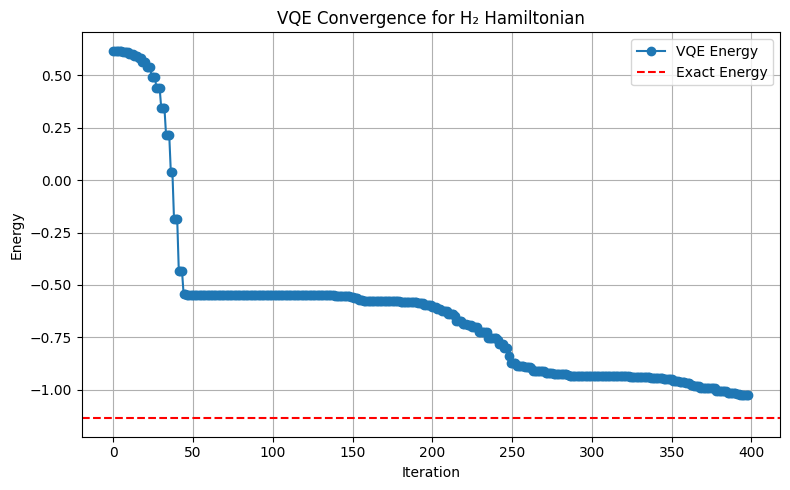

In [4]:

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import scipy.optimize as opt
import scipy.sparse

H = scipy.sparse.load_npz("h2_qubit_hamiltonian.npz").toarray()

dim = H.shape[0]
n_qubits = int(np.log2(dim))
print("Hamiltonian dimension:", dim)
print("n_qubits:", n_qubits)

def build_ansatz(params, n_qubits):
    qc = QuantumCircuit(n_qubits)
    p = np.array(params)

    for q in range(n_qubits):
        qc.ry(p[q], q)

    for q in range(n_qubits - 1):
        qc.cx(q, q + 1)

    for q in range(n_qubits):
        qc.ry(p[n_qubits + q], q)

    return qc

def expectation(params):
    qc = build_ansatz(params, n_qubits)
    sv = Statevector.from_instruction(qc).data
    sv = np.asarray(sv, dtype=complex).flatten()

    val = np.vdot(sv, H @ sv).real
    return val


energies = []

def callback(xk):
    e = expectation(xk)
    energies.append(e)
    print(f"Iter {len(energies)}, Energy = {e:.6f}")

init = np.random.normal(0, 0.3, 2 * n_qubits)

res = opt.minimize(expectation, init, method="Nelder-Mead", callback=callback, options={"maxiter": 400})

vqe_energy = res.fun
print("\nFinal VQE energy:", vqe_energy)


eigvals, _ = np.linalg.eigh(H)
exact_energy = np.min(eigvals)
print("Exact ground state energy:", exact_energy)


plt.figure(figsize=(8, 5))
plt.plot(energies, label="VQE Energy", marker="o")
plt.axhline(y=exact_energy, color="r", linestyle="--", label="Exact Energy")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VQE Convergence for H₂ Hamiltonian")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("vqe_convergence.png", dpi=200)
plt.show()


Hamiltonian dimension: 16, n_qubits: 4
Using ansatz with layers=4, n_params=32
Test circuit ops: OrderedDict([('ry', 32), ('cx', 16)])
Test circuit depth: 24
Starting optimization with L-BFGS-B. Max iters = 500
Eval   20, Energy = 0.627753840
Eval   40, Energy = -0.068440136
Eval   60, Energy = -0.068440135
Eval   80, Energy = -0.105084729
Eval  100, Energy = -0.465965546
Eval  120, Energy = -0.465965545
Eval  140, Energy = -0.800770375
Eval  160, Energy = -0.800770378
Eval  180, Energy = -0.942885241
Eval  200, Energy = -1.047966778
Eval  220, Energy = -1.047966778
Eval  240, Energy = -1.087268088
Eval  260, Energy = -1.087268087
Eval  280, Energy = -1.112393460
Eval  300, Energy = -1.124395175
Eval  320, Energy = -1.124395175
Eval  340, Energy = -1.132168129
Eval  360, Energy = -1.132168129
Eval  380, Energy = -1.133687283
Eval  400, Energy = -1.134875296
Eval  420, Energy = -1.134875296
Eval  440, Energy = -1.135659593
Eval  460, Energy = -1.135659593
Eval  480, Energy = -1.13606124

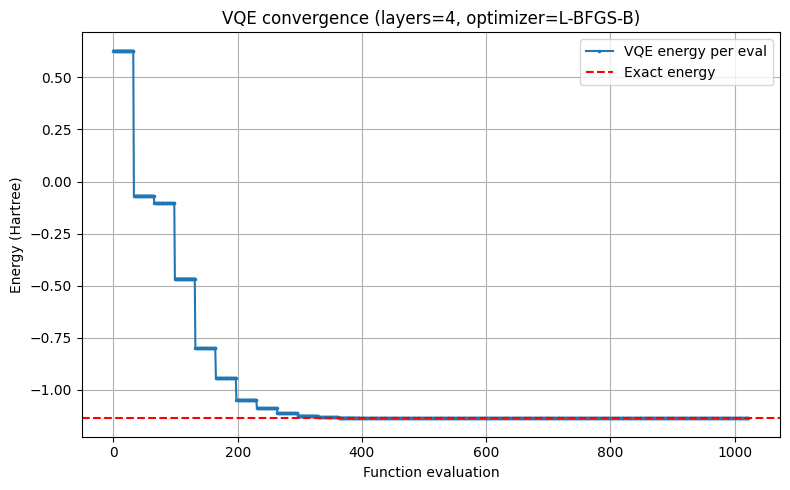


Final circuit counts: OrderedDict([('ry', 32), ('cx', 16)])
Final circuit depth: 24
Report written.


In [5]:

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import scipy.optimize as opt
import scipy.sparse
import time

H_FILE = "h2_qubit_hamiltonian.npz"
layers = 4             
optimizer_choice = "L-BFGS-B"  
maxiter = 500

H = scipy.sparse.load_npz(H_FILE).toarray().astype(complex)
dim = H.shape[0]
n_qubits = int(np.log2(dim))
print(f"Hamiltonian dimension: {dim}, n_qubits: {n_qubits}")

def build_deep_ansatz(params, n_qubits, layers):
    """
    param layout: layers * n_qubits for first rotation layer +
                  layers * n_qubits for second rotation layer (total = 2*layers*n_qubits)
    Here we use for each layer:
      - RY on each qubit (params[layer*n_qubits : (layer+1)*n_qubits])
      - entangling ring of CX
      - RY on each qubit (params[...])
    """
    qc = QuantumCircuit(n_qubits)
    p = np.array(params).reshape(2*layers, n_qubits)

    for L in range(layers):
        
        for q in range(n_qubits):
            qc.ry(p[2*L, q], q)
       
        for q in range(n_qubits):
            qc.cx(q, (q + 1) % n_qubits)
        
        for q in range(n_qubits):
            qc.ry(p[2*L + 1, q], q)

    return qc


energies = []
eval_count = {"n": 0}

def expectation(params):
    """Return <psi|H|psi> for the ansatz parametrized by params."""
    qc = build_deep_ansatz(params, n_qubits, layers)
    sv = Statevector.from_instruction(qc).data
    sv = np.asarray(sv, dtype=complex).flatten()
    Hv = H @ sv
    val = float(np.vdot(sv, Hv).real)
    energies.append(val)
    eval_count["n"] += 1

    if eval_count["n"] % 20 == 0:
        print(f"Eval {eval_count['n']:4d}, Energy = {val:.9f}")
    return val


def expectation_no_record(params):
    qc = build_deep_ansatz(params, n_qubits, layers)
    sv = Statevector.from_instruction(qc).data
    sv = np.asarray(sv, dtype=complex).flatten()
    return float(np.vdot(sv, H @ sv).real)


n_params = 2 * layers * n_qubits
print(f"Using ansatz with layers={layers}, n_params={n_params}")
init_params = np.random.normal(0, 0.1, n_params)


qc_test = build_deep_ansatz(init_params, n_qubits, layers)
print("Test circuit ops:", qc_test.count_ops())
print("Test circuit depth:", qc_test.depth())


print(f"Starting optimization with {optimizer_choice}. Max iters = {maxiter}")
t0 = time.time()

if optimizer_choice == "COBYLA":
    res = opt.minimize(expectation, init_params, method="COBYLA",
                       options={"maxiter": maxiter, "tol": 1e-6})
else:
    
    res = opt.minimize(expectation, init_params, method="L-BFGS-B",
                       options={"maxiter": maxiter, "ftol": 1e-9})

t1 = time.time()
print(f"Optimization done in {t1 - t0:.1f} s, evaluations: {eval_count['n']}")

vqe_energy = res.fun
print(f"\nFinal VQE energy: {vqe_energy:.12f} Hartree")
eigvals, _ = np.linalg.eigh(H)
exact_energy = float(np.min(eigvals))
print(f"Exact ground state energy: {exact_energy:.12f} Hartree")
print(f"Energy error (VQE - Exact): {vqe_energy - exact_energy:.6f} Hartree")


plt.figure(figsize=(8,5))
plt.plot(energies, marker='.', markersize=3, label='VQE energy per eval')
plt.axhline(y=exact_energy, color='r', linestyle='--', label='Exact energy')
plt.xlabel('Function evaluation')
plt.ylabel('Energy (Hartree)')
plt.title(f'VQE convergence (layers={layers}, optimizer={optimizer_choice})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"vqe_deeper_layers{layers}_{optimizer_choice}.png", dpi=200)
print(f"Saved plot to vqe_deeper_layers{layers}_{optimizer_choice}.png")
plt.show()


final_qc = build_deep_ansatz(res.x, n_qubits, layers)
print("\nFinal circuit counts:", final_qc.count_ops())
print("Final circuit depth:", final_qc.depth())


with open(f"vqe_deeper_layers{layers}_{optimizer_choice}_report.txt", "w") as f:
    f.write(f"layers = {layers}\n")
    f.write(f"optimizer = {optimizer_choice}\n")
    f.write(f"n_params = {n_params}\n")
    f.write(f"final_vqe_energy = {vqe_energy:.12f}\n")
    f.write(f"exact_energy = {exact_energy:.12f}\n")
    f.write(f"energy_error = {vqe_energy - exact_energy:.12f}\n")
    f.write(f"evals = {eval_count['n']}\n")
    f.write(f"circuit_ops = {final_qc.count_ops()}\n")
    f.write(f"circuit_depth = {final_qc.depth()}\n")

np.savetxt("vqe_deeper_layers4_L-BFGS-B_report_params.txt", res.x)

print("Report written.")


Model of H2 

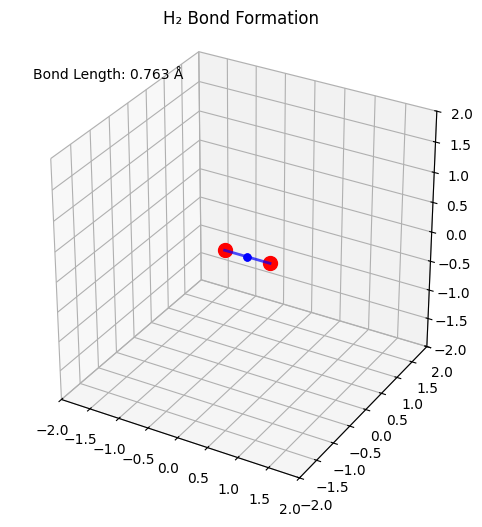

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

R_eq = bond_length_eq 
electron_radius = 0.7938  

R_values = np.linspace(2.0, R_eq, 40)
R_values = np.concatenate([R_values, np.full(20, R_eq)])  


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_zlim([-2, 2])
ax.set_box_aspect([1, 1, 1])
ax.set_title("H₂ Bond Formation")


nucleus1, = ax.plot([], [], [], "ro", markersize=10)
nucleus2, = ax.plot([], [], [], "ro", markersize=10)
electron1, = ax.plot([], [], [], "bo", markersize=5)
electron2, = ax.plot([], [], [], "bo", markersize=5)
bond_line, = ax.plot([], [], [], "b-", linewidth=2, alpha=0.7)
distance_text = ax.text2D(0.05, 0.9, "", transform=ax.transAxes)

def init():
    return nucleus1, nucleus2, electron1, electron2, bond_line, distance_text

def update(frame):
    R = R_values[frame]

    x1, y1, z1 = -R/2, 0, 0
    x2, y2, z2 =  R/2, 0, 0
    nucleus1.set_data([x1], [y1])
    nucleus1.set_3d_properties([z1])
    nucleus2.set_data([x2], [y2])
    nucleus2.set_3d_properties([z2])

    if R > R_eq + 0.05:
        phi = 2 * np.pi * frame / len(R_values)
        electron1.set_data([x1 + electron_radius*np.cos(phi)], [y1 + electron_radius*np.sin(phi)])
        electron1.set_3d_properties([electron_radius*np.sin(phi)])
        electron2.set_data([x2 + electron_radius*np.cos(phi+np.pi)], [y2 + electron_radius*np.sin(phi+np.pi)])
        electron2.set_3d_properties([electron_radius*np.sin(phi+np.pi)])
        bond_line.set_data([], [])
        bond_line.set_3d_properties([])
    else:
        electron1.set_data([(x1 + x2)/2], [(y1 + y2)/2])
        electron1.set_3d_properties([(z1 + z2)/2])
        electron2.set_data([(x1 + x2)/2], [(y1 + y2)/2])
        electron2.set_3d_properties([(z1 + z2)/2])
        bond_line.set_data([x1, x2], [y1, y2])
        bond_line.set_3d_properties([z1, z2])

    distance_text.set_text(f"Bond Length: {R:.3f} Å")
    return nucleus1, nucleus2, electron1, electron2, bond_line, distance_text


ani = FuncAnimation(fig, update, frames=len(R_values),
                    init_func=init, blit=False, interval=200, repeat=True)


HTML(ani.to_jshtml())


Excited state (Future work)

Hamiltonian shape: (16, 16), n_qubits = 4
Lowest eigenvalues (Hartree):
  E[0] = -1.136663535399 Hartree = -30.930190 eV
  E[1] = -0.557982029840 Hartree = -15.183465 eV
  E[2] = -0.557982029840 Hartree = -15.183465 eV
  E[3] = -0.557982029840 Hartree = -15.183465 eV
  E[4] = -0.546019649223 Hartree = -14.857952 eV
  E[5] = -0.546019649223 Hartree = -14.857952 eV

Gap E1-E0 = 5.786815055592e-01 Hartree = 15.746726 eV

State: ground
  - Top 6 basis states by probability:
    |1100>  p = 0.9862
    |0011>  p = 0.0138
    |1110>  p = 0.0000
    |1111>  p = 0.0000
    |1011>  p = 0.0000
    |1010>  p = 0.0000
  - Occupation (per qubit) [<n_i>]:
    qubit 0: 0.986240
    qubit 1: 0.986240
    qubit 2: 0.013760
    qubit 3: 0.013760

State: first excited
  - Top 6 basis states by probability:
    |0101>  p = 1.0000
    |1111>  p = 0.0000
    |1101>  p = 0.0000
    |1110>  p = 0.0000
    |1011>  p = 0.0000
    |1010>  p = 0.0000
  - Occupation (per qubit) [<n_i>]:
    qubit 0: 0.000000
    qu

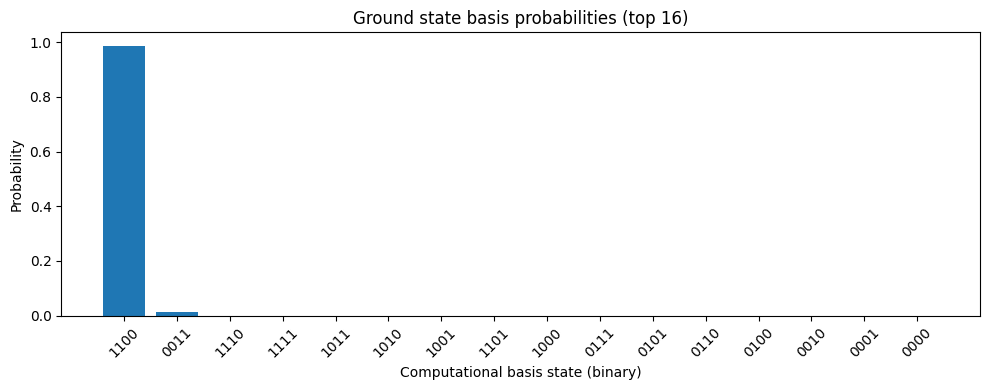

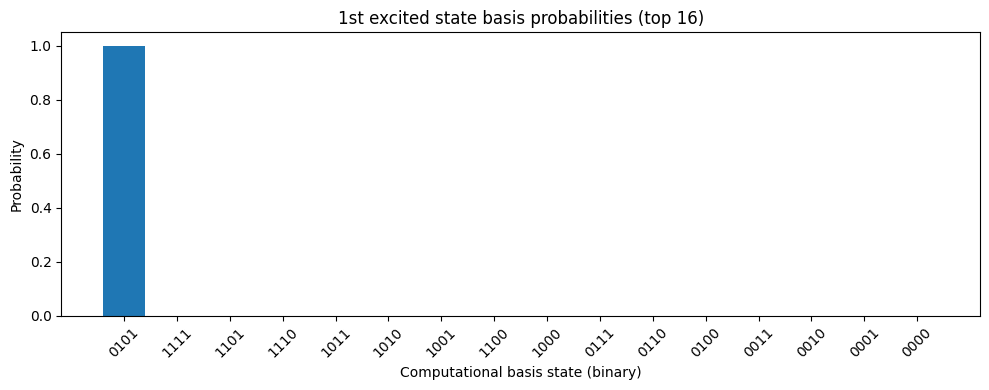

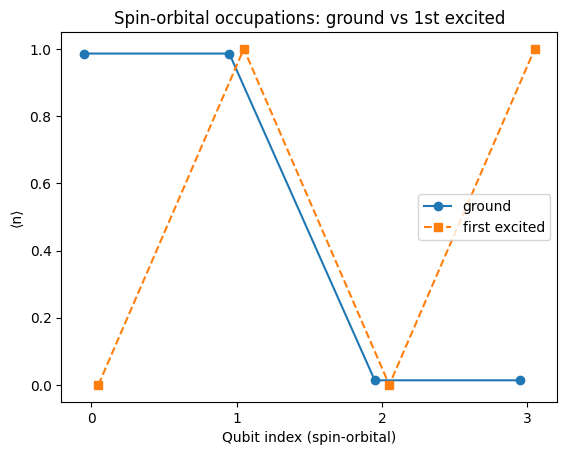

Energy gap (Hartree) = 5.786815e-01; expected oscillation angular freq ~ 5.786815e-01 a.u.


In [7]:

import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt


H_npz = "h2_qubit_hamiltonian.npz"   
hartree_to_ev = 27.211386245988      

H = la.inv(np.eye(1))  
try:
    import scipy.sparse
    H = scipy.sparse.load_npz(H_npz).todense()
except Exception as e:
    H = np.load(H_npz, allow_pickle=True)
    if isinstance(H, np.ndarray) and H.shape == ():
        try:
            H = H['arr_0']
        except Exception:
            pass
H = np.asarray(H, dtype=complex)
dim = H.shape[0]
n_qubits = int(np.log2(dim))
print(f"Hamiltonian shape: {H.shape}, n_qubits = {n_qubits}")


eigvals, eigvecs = la.eigh(H)
print("Lowest eigenvalues (Hartree):")
for i, e in enumerate(eigvals[:6]):
    print(f"  E[{i}] = {e:.12f} Hartree = {e*hartree_to_ev:.6f} eV")

E0 = eigvals[0]
E1 = eigvals[1]
gap_H = E1 - E0
print(f"\nGap E1-E0 = {gap_H:.12e} Hartree = {gap_H*hartree_to_ev:.6f} eV")


Z = np.array([[1, 0], [0, -1]], dtype=complex)
I2 = np.eye(2, dtype=complex)
def kron_many(mats):
    out = np.array([[1.0]], dtype=complex)
    for M in mats:
        out = np.kron(out, M)
    return out

def number_operator_on_qubit(q, n_qubits):
    ops = []
    for i in range(n_qubits):
        ops.append((I2 - Z) / 2 if i == q else I2)
    return kron_many(ops)


n_ops = [number_operator_on_qubit(q, n_qubits) for q in range(n_qubits)]


def analyze_state(vec, state_label=""):
    vec = np.asarray(vec).reshape(-1)
    probs = np.abs(vec)**2
    labels = [format(i, f"0{n_qubits}b") for i in range(dim)]
    occs = np.array([np.vdot(vec, n_ops[q] @ vec).real for q in range(n_qubits)])
    print(f"\nState: {state_label}")
    print("  - Top 6 basis states by probability:")
    top_idx = np.argsort(probs)[-6:][::-1]
    for idx in top_idx:
        print(f"    |{labels[idx]}>  p = {probs[idx]:.4f}")
    print("  - Occupation (per qubit) [<n_i>]:")
    for q in range(n_qubits):
        print(f"    qubit {q}: {occs[q]:.6f}")
    return probs, labels, occs


psi_g = eigvecs[:, 0]
probs_g, labels_g, occs_g = analyze_state(psi_g, "ground")


psi_e1 = eigvecs[:, 1]
probs_e1, labels_e1, occs_e1 = analyze_state(psi_e1, "first excited")


def plot_state_probabilities(probs, labels, title="State probabilities", top_n=16):
    idx_sorted = np.argsort(probs)[-top_n:][::-1]
    fig, ax = plt.subplots(figsize=(10,4))
    ax.bar(range(len(idx_sorted)), probs[idx_sorted], tick_label=[labels[i] for i in idx_sorted])
    ax.set_xlabel("Computational basis state (binary)")
    ax.set_ylabel("Probability")
    ax.set_title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    return fig, ax

plot_state_probabilities(probs_g, labels_g, "Ground state basis probabilities (top 16)")
plot_state_probabilities(probs_e1, labels_e1, "1st excited state basis probabilities (top 16)")
plt.show()


fig, ax = plt.subplots()
x = np.arange(n_qubits)
ax.plot(x - 0.05, occs_g, 'o-', label="ground")
ax.plot(x + 0.05, occs_e1, 's--', label="first excited")
ax.set_xlabel("Qubit index (spin-orbital)")
ax.set_ylabel("⟨n⟩")
ax.set_title("Spin-orbital occupations: ground vs 1st excited")
ax.set_xticks(x)
ax.legend()
plt.show()


omega_gap = gap_H  
print(f"Energy gap (Hartree) = {gap_H:.6e}; expected oscillation angular freq ~ {omega_gap:.6e} a.u.")
